# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import math
import json
import pandas as pd
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import progressbar
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, recall_score, f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.externals import joblib

In [2]:
#Set up the colors for seaborn (Although I will change it often throughout to give some different colors for each)
% matplotlib inline
plt.style.use('seaborn-darkgrid')
sns.set_style('darkgrid')
% matplotlib inline

In [3]:
# bring in json files
port = pd.read_json('data/portfolio.json', orient='records', lines=True)
prof = pd.read_json('data/profile.json', orient='records', lines=True)
trans = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
#Review portfolio json
port.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
port.shape

(10, 6)

In [6]:
port.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [7]:
#Review Profile json
prof.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
prof.shape

(17000, 5)

In [9]:
prof.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [91]:
#Change Default Colors
sns.set_palette("PuBuGn_d")

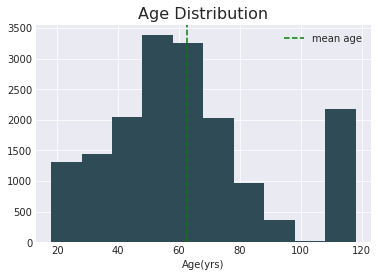

In [11]:
#View Age Distribution from Profile
prof['age'].hist();
plt.axvline(prof['age'].mean(), color = 'green', linestyle = '--', label = 'mean age')
plt.title('Age Distribution', fontsize = 16, y = 1)
plt.xlabel('Age(yrs)')
plt.legend()
plt.show()

In [12]:
#Whoa! Thats alot of people 118. Lets fix that.

In [13]:
def clean_prof(prof):
    '''
    fix some of the issues with prof dataset
    
    INPUT:
    prof - the profile dataframe that needs fixing
    
    OUTPUT:
    prof - the dataframe that is easier to use
    
    '''
    prof['age'] = prof['age'].apply(lambda x: np.nan if x == 118 else x)   
    prof.dropna(inplace=True)
    prof['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(prof['became_member_on'], format='%Y%m%d').dt.date
    prof['memberdays'] = prof['memberdays'].dt.days
    
    return prof

In [14]:
clean_prof(prof)

,age,became_member_on,gender,id,income,memberdays
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1052
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1119
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,767
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,843
12,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,933
13,61.0,20170911,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,994
14,26.0,20140213,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,2300
15,62.0,20160211,F,31dda685af34476cad5bc968bdb01c53,71000.0,1572
16,49.0,20141113,M,62cf5e10845442329191fc246e7bcea3,52000.0,2027
18,57.0,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0,883


In [15]:
port.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [16]:
#Check largest Ages
prof.sort_values(by=['age']).tail()

,age,became_member_on,gender,id,income,memberdays
15800,101.0,20170309,F,047ad0135cfe4c0ea5ba019da4de9c52,59000.0,1180
4100,101.0,20150526,F,d2fdc2be8ab64e4ba04830d441e53fd5,99000.0,1833
14846,101.0,20171109,F,e0ea90ddd2f147e082d21e97f51ec1b1,56000.0,935
16864,101.0,20171127,F,1593d617fac246ef8e50dbb0ffd77f5f,82000.0,917
1556,101.0,20171004,F,4d2ccfcbbebf4bd9baf4b7e433d0e288,43000.0,971


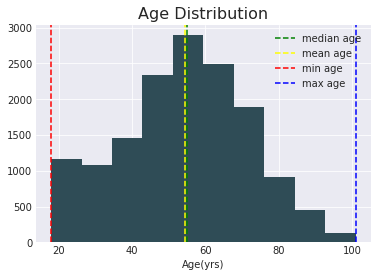

Median Age : 55.0
Mean Age : 54.4
Min Age : 18.0
Min Age : 101.0


In [92]:
#Redo graph with profile fixed
prof['age'].hist();
plt.axvline(prof['age'].median(), color = 'green', linestyle = '--', label = 'median age')
plt.axvline(prof['age'].mean(), color = 'yellow', linestyle = '--', label = 'mean age')
plt.axvline(prof['age'].min(), color = 'red', linestyle = '--', label = 'min age')
plt.axvline(prof['age'].max(), color = 'blue', linestyle = '--', label = 'max age')
plt.title('Age Distribution', fontsize = 16, y = 1)
plt.xlabel('Age(yrs)')
plt.legend()
plt.show()


print('Median Age : {}'.format(prof['age'].median()))
print('Mean Age : {}'.format(round(prof['age'].mean(), 1)))
print('Min Age : {}'.format(prof['age'].min()))
print('Min Age : {}'.format(prof['age'].max()))

In [18]:
prof.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

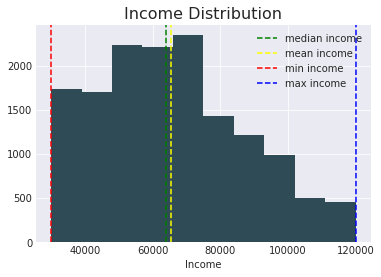

Median Income : 64000.0
Mean Income : 65405.0
Min Income : 30000.0
Min Income : 120000.0


In [19]:
prof['income'].hist();
plt.axvline(prof['income'].median(), color = 'green', linestyle = '--', label = 'median income')
plt.axvline(prof['income'].mean(), color = 'yellow', linestyle = '--', label = 'mean income')
plt.axvline(prof['income'].min(), color = 'red', linestyle = '--', label = 'min income')
plt.axvline(prof['income'].max(), color = 'blue', linestyle = '--', label = 'max income')
plt.title('Income Distribution', fontsize = 16, y = 1)
plt.xlabel('Income')
plt.legend()
plt.show()

print('Median Income : {}'.format(prof['income'].median()))
print('Mean Income : {}'.format(round(prof['income'].mean(), 1)))
print('Min Income : {}'.format(prof['income'].min()))
print('Min Income : {}'.format(prof['income'].max()))

In [20]:
#GENDER
prof['gender'].value_counts()/len(prof['gender'].dropna())*100

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

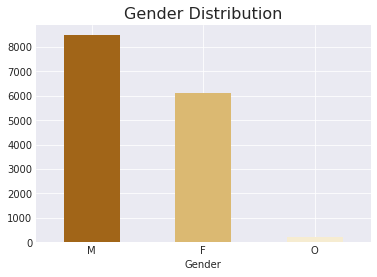

In [21]:
sns.set_palette("BrBG")
prof['gender'].value_counts().plot(kind='bar')
plt.xticks(rotation = 0)
plt.title('Gender Distribution', fontsize = 16, y = 1)
plt.xlabel('Gender')
plt.show()

In [22]:
print('{}'.format(prof['gender'].value_counts()))



M    8484
F    6129
O     212
Name: gender, dtype: int64


In [23]:
prof['became_member_on'] = pd.to_datetime(prof['became_member_on'], format='%Y%m%d')

In [24]:
prof['member_since_year'] = prof['became_member_on'].dt.year

In [25]:
prof['member_for_days'] = pd.to_datetime('20180926',format='%Y%m%d')
prof['member_for_days'] = round(((prof['member_for_days'] - prof['became_member_on'])/np.timedelta64(1, 'D')))

In [26]:
prof.head()

,age,became_member_on,gender,id,income,memberdays,member_since_year,member_for_days
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1052,2017,438.0
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1119,2017,505.0
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,767,2018,153.0
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,843,2018,229.0
12,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,933,2017,319.0


In [27]:
prof.isnull().sum()

age                  0
became_member_on     0
gender               0
id                   0
income               0
memberdays           0
member_since_year    0
member_for_days      0
dtype: int64

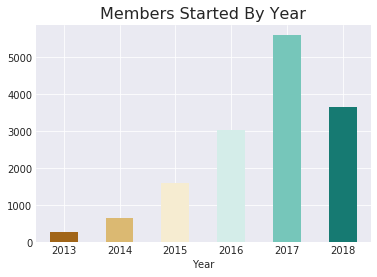

In [28]:
prof.groupby('member_since_year').count()['id'].plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.title('Members Started By Year', fontsize = 16, y = 1)
plt.xlabel('Year')
plt.show()

In [29]:
prof.sort_values(by = 'became_member_on').tail(1)

,age,became_member_on,gender,id,income,memberdays,member_since_year,member_for_days
4357,76.0,2018-07-26,M,6597e5ab63754726b83ba2032f008d26,92000.0,676,2018,62.0


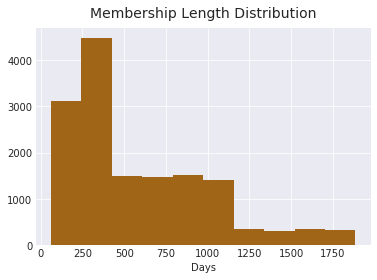

In [30]:
prof['member_for_days'].hist()
plt.title('Membership Length Distribution', fontsize = 14, y = 1.02)
plt.xlabel('Days')
plt.show()

In [31]:
#sets color of sns graph
sns.set_palette("husl")

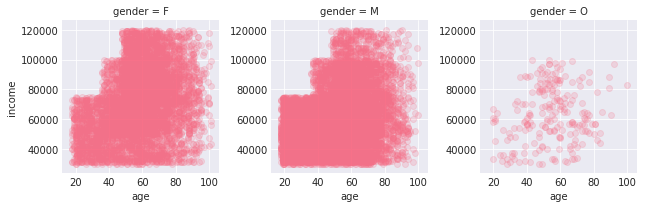

In [32]:
gend = sns.FacetGrid(data = prof, col = 'gender')
gend.map(plt.scatter, 'age', 'income', alpha=0.2);
gend.add_legend();

In [33]:
prof.head()

,age,became_member_on,gender,id,income,memberdays,member_since_year,member_for_days
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1052,2017,438.0
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1119,2017,505.0
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,767,2018,153.0
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,843,2018,229.0
12,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,933,2017,319.0


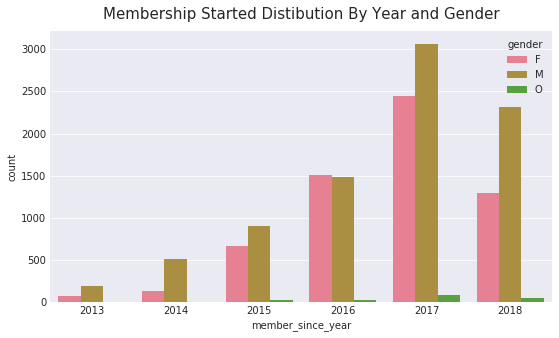

In [34]:
plt.figure(figsize=(9, 5))
mem_since_plot = sns.countplot(data = prof, x = 'member_since_year', hue = 'gender')
mem_since_plot.set_title('Membership Started Distibution By Year and Gender', fontsize = 15, y = 1.02);

# Data Review

### Based on there data set there are some characteristics that we have discovered:
1. Total number of people - 14,825
2. Total Men - 8484
3. Total Women - 6129
4. Total Undisclosed - 212
5. A large part of the members are new members
6. Most users are 50 years or greater
7. Median Income - 64000
8. Mean Income - 65405
9. Mean Age - 54.4

## Deeper Data Analysis on Portfolio

In [35]:
port

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [36]:
port['offer_name'] = port['offer_type'] + '_' + port['difficulty'].astype(str) + '_' \
    + port['reward'].astype(str) + '_' + port['duration'].astype(str)

In [37]:
ohe_channels = port['channels'].str.join(',').str.get_dummies(',')
port = pd.concat([port, ohe_channels], axis = 1)
port.drop(['channels'], axis = 1, inplace = True)

In [38]:
port['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

## Deeper Data Analysis on Transcript

In [39]:
trans.shape

(306534, 4)

In [40]:
trans.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [41]:
trans.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


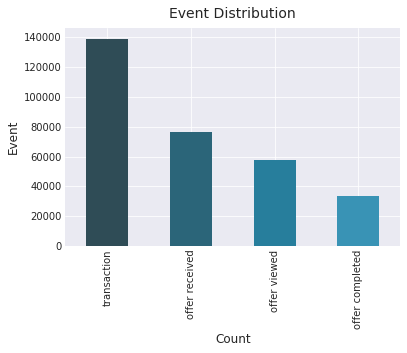

In [111]:
trans['event'].value_counts().plot(kind = 'bar')
plt.title('Event Distribution', fontsize = 14, y = 1.02)
plt.ylabel('Event', fontsize= 12)
plt.xlabel('Count', fontsize= 12)
plt.show()

In [43]:
prof.dropna(inplace = True)

In [44]:
prof.rename(columns = {'id' : 'person'}, inplace = True)

In [45]:
trans['trans_amount'] = 0
trans['offer_id'] = np.nan

In [46]:
def return_trans_amount(dic):
    if 'amount' in dic.keys():
        return dic['amount']
    else:
        return 0

def return_offer_id(dic):
    if 'offer id' in dic.keys():
        return dic['offer id']
    elif 'offer_id' in dic.keys():
        return dic['offer_id']
    else:
        return np.nan

In [47]:
trans['trans_amount'] = trans['value'].apply(lambda x: return_trans_amount(x))
trans['offer_id'] = trans['value'].apply(lambda x: return_offer_id(x))

In [48]:
port.rename(columns = {'id' : 'offer_id'}, inplace = True)

In [49]:
trans = trans.merge(port, how = 'left', on = 'offer_id')

In [50]:
trans.drop(['value'], inplace = True, axis = 1)

In [51]:
trans.head()

,event,person,time,trans_amount,offer_id,difficulty,duration,offer_type,reward,offer_name,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,bogo,5.0,bogo_5_5_7,1.0,1.0,0.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,discount,5.0,discount_20_5_10,1.0,0.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,0.0,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,discount,2.0,discount_10_2_7,1.0,1.0,0.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,10.0,10.0,discount,2.0,discount_10_2_10,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,5.0,bogo,10.0,bogo_10_10_5,1.0,1.0,1.0,1.0


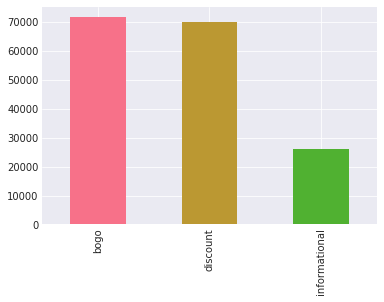

In [52]:
trans['offer_type'].value_counts().plot(kind = 'bar');

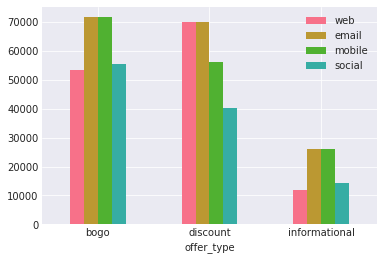

In [53]:
trans.groupby('offer_type')['web', 'email', 'mobile', 'social'].sum().plot(kind = 'bar')
plt.xticks(rotation = 0)

plt.show()

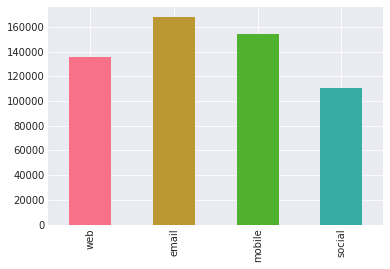

In [54]:
trans[['web', 'email', 'mobile', 'social']].sum().plot('bar');

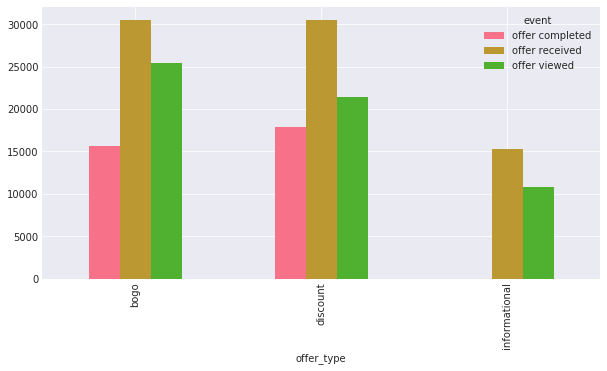

In [55]:
trans.groupby(['event', 'offer_type'])['offer_type'].count().unstack(0).plot.bar(figsize = (10,5))

In [56]:
trans = trans.sort_values(['person', 'time'])

In [57]:
trans_viewed = trans[(trans['event']=='transaction') |\
                          (trans['event']=='offer viewed')].sort_values(['person', 'time']).fillna(method = 'ffill')

In [58]:
trans.loc[trans_viewed.index] = trans_viewed

In [59]:
trans.reset_index(inplace = True, drop = True)

In [60]:
cols = port['offer_id'].tolist()
new_df1 = pd.DataFrame(np.nan, index = prof['person'].tolist(), columns = cols)
cols_new = ['trans_for_offer','trans_count','trans_total']
new_df2 = pd.DataFrame(np.zeros((prof.shape[0], 3)), index = prof['person'].tolist(), columns = cols_new)
prof_trans = pd.concat([new_df1, new_df2], axis = 1)

In [61]:
def get_trans_recs(person):
    
    '''Fetches transaction records from trans dataset for 
    a particular user.
    
    INPUT:
        person (str): id of user
    OUTPUT:
        trans_recs (dataframe): trans record for the particular user
    '''
    
    trans_recs = trans[trans['person'] == person].reset_index(drop=True)
    
    return trans_recs

In [62]:
bogo_discount_offer_ids = port[port['offer_type'].isin(['bogo', 'discount'])]['offer_id'].values

cnter = 0
pbar = progressbar.ProgressBar(maxval=prof_trans.shape[0], widgets=[progressbar.Bar('=', '[', ']'), progressbar.Percentage()])
pbar.start()

for person_ind in range(prof_trans.shape[0]):
    cnter+=1 
    pbar.update(cnter)
    
    person = prof_trans.index[person_ind]
    trans_recs = get_trans_recs(person)
    offer_view_count = defaultdict(int)
    offer_comp_count = defaultdict(int)
    off_rec_ind = trans_recs[trans_recs['event'] == 'offer received'].index.values
    transactions = trans_recs[trans_recs.event == 'transaction']
    prof_trans.loc[person, 'trans_count'] = transactions.shape[0]
    prof_trans.loc[person, 'trans_total'] = transactions['trans_amount'].sum()

    trans_off_ind = []
    
    for r_i in off_rec_ind:
        offer_id = trans_recs.loc[r_i, 'offer_id']
        offer_valid_for = int(port[port['offer_id'] == offer_id]['duration']) * 24
        offer_start = trans_recs.loc[r_i, 'time']
        offer_end = offer_start + offer_valid_for
        
        viewed = trans_recs[(trans_recs['offer_id'] == offer_id) &
                           (trans_recs['event'] == 'offer viewed') &
                           (trans_recs['time'] >= offer_start) &
                           (trans_recs['time'] <= offer_end)]
        
        if viewed.shape[0] < 1:
            continue
        
        else:
            if offer_id in bogo_discount_offer_ids:
                completed = trans_recs[(trans_recs['offer_id'] == offer_id) &
                           (trans_recs['event'] == 'offer completed') &
                           (trans_recs['time'] >= offer_start) &
                           (trans_recs['time'] <= offer_end)]
                if completed.shape[0] < 1 :
                    offer_view_count[offer_id] += 1
                    offer_comp_count[offer_id] += 0
                else:
                    view_ind = viewed.index[0]
                    comp_ind = completed.index[0]
                    if view_ind < comp_ind:
                        offer_view_count[offer_id] += 1
                        offer_comp_count[offer_id] += 1
                        trans_off_ind.extend(transactions.loc[view_ind:comp_ind].index.values)
                    else:
                        continue
            else:
                view_time = viewed.iloc[0]['time']
                offer_view_count[offer_id] +=1
                info_trans = trans_recs[(trans_recs['event'] == 'transaction') &
                                       (trans_recs['time'] >= view_time) &
                                       (trans_recs['time'] <= offer_end)]
                if info_trans.shape[0] > 0:
                    offer_comp_count[offer_id] += 1
                else:
                    offer_comp_count[offer_id] += 0
    
    for off_id in offer_view_count.keys():
        prof_trans.loc[person, off_id] = offer_comp_count[off_id]/offer_view_count[off_id]
        
    if len(trans_off_ind) > 0:
        prof_trans.loc[person, 'trans_for_offer'] = transactions.loc[list(set(trans_off_ind))]['trans_amount'].sum()

In [63]:
prof_trans['avg_trans'] = (prof_trans['trans_total']/prof_trans['trans_count'] + 0.001)
prof_trans['trans_offer_ratio'] = (prof_trans['trans_for_offer']/prof_trans['trans_total'] + 0.001)
prof_trans.drop(['trans_for_offer', 'trans_count'], inplace=True, axis=1)

In [64]:
prof.set_index(['person'], inplace=True, drop=True)
prof.index.name = None

In [65]:
prof_trans = prof_trans.join(prof)

In [66]:
prof_trans.to_csv('prof_trans.csv')

In [67]:
prof_trans.head()

,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5,trans_total,avg_trans,trans_offer_ratio,age,became_member_on,gender,income,memberdays,member_since_year,member_for_days
0610b486422d4921ae7d2bf64640c50b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.01,25.671000,0.001000,55.0,2017-07-15,F,112000.0,1052,2017,438.0
78afa995795e4d85b5d9ceeca43f5fef,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,159.27,22.753857,0.262254,75.0,2017-05-09,F,100000.0,1119,2017,505.0
e2127556f4f64592b11af22de27a7932,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,0.0,57.73,19.244333,0.320072,68.0,2018-04-26,M,70000.0,767,2018,153.0
389bc3fa690240e798340f5a15918d5c,NaN,NaN,NaN,0.5,NaN,NaN,1.0,NaN,1.0,1.0,36.43,12.144333,1.001000,65.0,2018-02-09,M,53000.0,843,2018,229.0
2eeac8d8feae4a8cad5a6af0499a211d,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,15.62,3.906000,0.796775,58.0,2017-11-11,M,51000.0,933,2017,319.0


In [103]:
prof_trans = pd.read_csv('prof_trans.csv', index_col= 'Unnamed: 0')
prof_trans.index.name = None

In [104]:
offer_ids = port.offer_id.tolist()
offer_names = port.offer_name.tolist()
offer_dict = {}
for i,v in enumerate(offer_ids):
    offer_dict[v] = offer_names[i]

In [105]:
prof_trans.rename(offer_dict, axis = 1, inplace=True)
prof_trans.tail()

,bogo_10_10_7,bogo_10_10_5,informational_0_0_4,bogo_5_5_7,discount_20_5_10,discount_7_3_7,discount_10_2_10,informational_0_0_3,bogo_5_5_5,discount_10_2_7,trans_total,avg_trans,trans_offer_ratio,age,became_member_on,gender,income,memberdays,member_since_year,member_for_days
6d5f3a774f3d4714ab0c092238f3a1d7,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,20.03,2.862429,0.001000,45.0,2018-06-04,F,54000.0,728,2018,114.0
2cb4f97358b841b9a9773a7aa05a9d77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,25.97,3.711000,0.001000,61.0,2018-07-13,M,72000.0,689,2018,75.0
01d26f638c274aa0b965d24cefe3183f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,39.74,4.968500,0.001000,49.0,2017-01-26,M,73000.0,1222,2017,608.0
9dc1421481194dcd9400aec7c9ae6366,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189.67,13.548857,0.107712,83.0,2016-03-07,F,50000.0,1547,2016,933.0
e4052622e5ba45a8b96b59aba68cf068,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,143.02,23.837667,0.151678,62.0,2017-07-22,F,82000.0,1045,2017,431.0


## Deeper Data Analysis on Transactions and Profiles

In [106]:
prof_trans[['age', 'income', 'member_for_days', 'trans_total', 'avg_trans', 'trans_offer_ratio']].describe()

,age,income,member_for_days,trans_total,avg_trans,trans_offer_ratio
count,14825.000000,14825.000000,14825.000000,14825.000000,14492.000000,14492.000000
mean,54.393524,65404.991568,584.478988,117.028155,15.253287,0.266192
std,17.383705,21598.299410,419.205158,129.965016,16.543371,0.237455
min,18.000000,30000.000000,62.000000,0.000000,0.151000,0.001000
25%,42.000000,49000.000000,270.000000,31.450000,3.891833,0.027994
50%,55.000000,64000.000000,420.000000,87.040000,14.312214,0.237432
75%,66.000000,80000.000000,859.000000,160.900000,21.468625,0.401444
max,101.000000,120000.000000,1885.000000,1608.690000,451.471000,1.001000


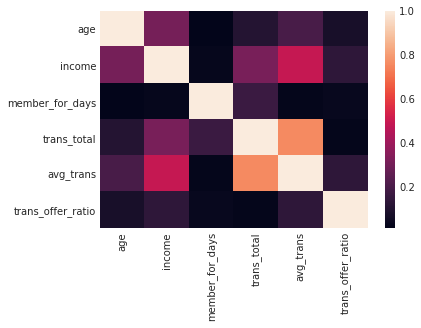

In [107]:
sns.heatmap(prof_trans[['age', 'income', 'member_for_days', 'trans_total', 'avg_trans', 'trans_offer_ratio']].corr());

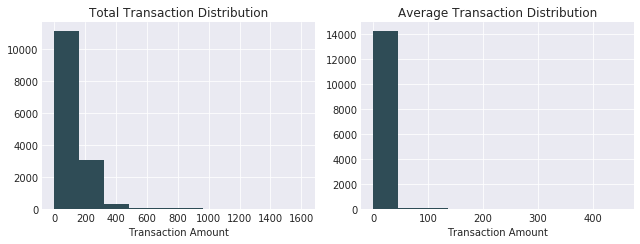

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(9,3.5))
prof_trans['trans_total'].hist(ax = axes[0]);
axes[0].set_title('Total Transaction Distribution')
axes[0].set_xlabel('Transaction Amount',)
prof_trans['avg_trans'].hist(ax = axes[1]);
axes[1].set_title('Average Transaction Distribution')
axes[1].set_xlabel('Transaction Amount')
plt.tight_layout()
plt.show()

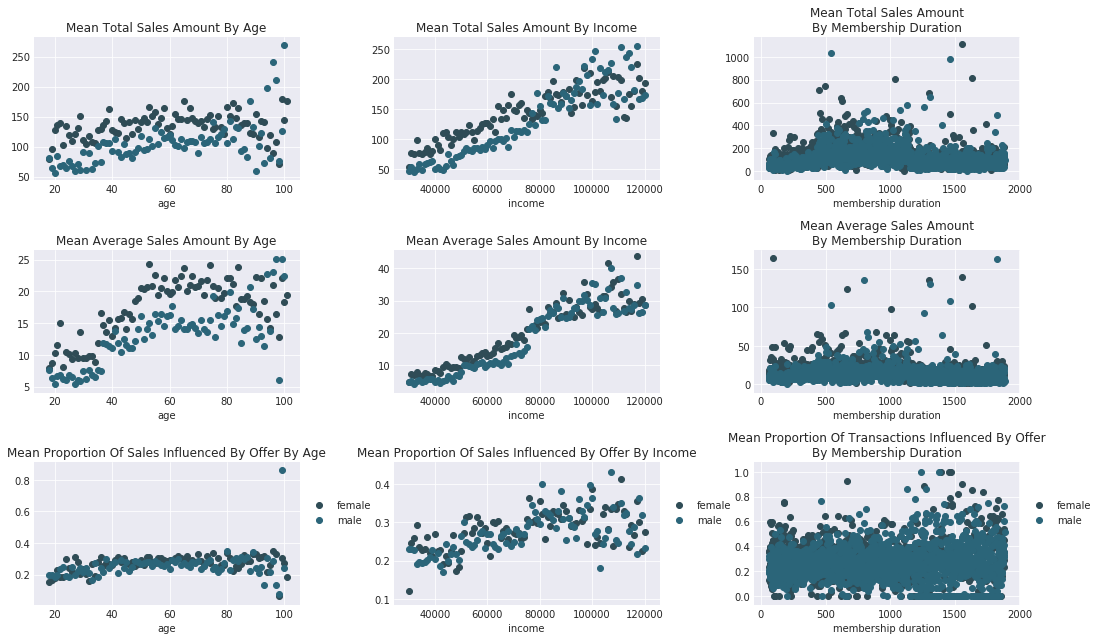

In [110]:
fig = plt.figure(figsize=(15,9))

plt.subplot(3,3,1)
female_avg = prof_trans[prof_trans.gender=='F'].groupby('age').mean()['trans_total']
male_avg = prof_trans[prof_trans.gender=='M'].groupby('age').mean()['trans_total']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('age');
plt.title('Mean Total Sales Amount By Age')

plt.subplot(3,3,2)
female_avg = prof_trans[prof_trans.gender=='F'].groupby('income').mean()['trans_total']
male_avg = prof_trans[prof_trans.gender=='M'].groupby('income').mean()['trans_total']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('income');
plt.title('Mean Total Sales Amount By Income')

plt.subplot(3,3,3)
female_avg = prof_trans[prof_trans.gender=='F'].groupby('member_for_days').mean()['trans_total']
male_avg = prof_trans[prof_trans.gender=='M'].groupby('member_for_days').mean()['trans_total']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('membership duration');
plt.title('Mean Total Sales Amount\nBy Membership Duration')

plt.subplot(3,3,4)
female_avg = prof_trans[prof_trans.gender=='F'].groupby('age').mean()['avg_trans']
male_avg = prof_trans[prof_trans.gender=='M'].groupby('age').mean()['avg_trans']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('age');
plt.title('Mean Average Sales Amount By Age')

plt.subplot(3,3,5)
female_avg = prof_trans[prof_trans.gender=='F'].groupby('income').mean()['avg_trans']
male_avg = prof_trans[prof_trans.gender=='M'].groupby('income').mean()['avg_trans']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('income');
plt.title('Mean Average Sales Amount By Income')

plt.subplot(3,3,6)
female_avg = prof_trans[prof_trans.gender=='F'].groupby('member_for_days').mean()['avg_trans']
male_avg = prof_trans[prof_trans.gender=='M'].groupby('member_for_days').mean()['avg_trans']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('membership duration');
plt.title('Mean Average Sales Amount\nBy Membership Duration')

plt.subplot(3,3,7)
female_avg = prof_trans[prof_trans.gender=='F'].groupby('age').mean()['trans_offer_ratio']
male_avg = prof_trans[prof_trans.gender=='M'].groupby('age').mean()['trans_offer_ratio']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('age');
plt.title('Mean Proportion Of Sales Influenced By Offer By Age')
plt.legend(['female', 'male'], bbox_to_anchor=(1.00, 0.5), loc=3);

plt.subplot(3,3,8)
female_avg = prof_trans[prof_trans.gender=='F'].groupby('income').mean()['trans_offer_ratio']
male_avg = prof_trans[prof_trans.gender=='M'].groupby('income').mean()['trans_offer_ratio']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('income');
plt.title('Mean Proportion Of Sales Influenced By Offer By Income')
plt.legend(['female', 'male'], bbox_to_anchor=(1.00, 0.5), loc=3);

plt.subplot(3,3,9)
female_avg = prof_trans[prof_trans.gender=='F'].groupby('member_for_days').mean()['trans_offer_ratio']
male_avg = prof_trans[prof_trans.gender=='M'].groupby('member_for_days').mean()['trans_offer_ratio']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('membership duration');
plt.title('Mean Proportion Of Transactions Influenced By Offer\nBy Membership Duration')
plt.legend(['female', 'male'], bbox_to_anchor=(1.00, 0.5), loc=3);

plt.tight_layout()
plt.show()

## Data Analysis and Predictions of Best Offers

In [77]:
prof_trans.head()

,bogo_10_10_7,bogo_10_10_5,informational_0_0_4,bogo_5_5_7,discount_20_5_10,discount_7_3_7,discount_10_2_10,informational_0_0_3,bogo_5_5_5,discount_10_2_7,trans_total,avg_trans,trans_offer_ratio,age,became_member_on,gender,income,memberdays,member_since_year,member_for_days
0610b486422d4921ae7d2bf64640c50b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.01,25.671000,0.001000,55.0,2017-07-15,F,112000.0,1052,2017,438.0
78afa995795e4d85b5d9ceeca43f5fef,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,159.27,22.753857,0.262254,75.0,2017-05-09,F,100000.0,1119,2017,505.0
e2127556f4f64592b11af22de27a7932,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,0.0,57.73,19.244333,0.320072,68.0,2018-04-26,M,70000.0,767,2018,153.0
389bc3fa690240e798340f5a15918d5c,NaN,NaN,NaN,0.5,NaN,NaN,1.0,NaN,1.0,1.0,36.43,12.144333,1.001000,65.0,2018-02-09,M,53000.0,843,2018,229.0
2eeac8d8feae4a8cad5a6af0499a211d,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,15.62,3.906000,0.796775,58.0,2017-11-11,M,51000.0,933,2017,319.0


In [78]:
one_hot = pd.get_dummies(prof_trans['gender'])
prof_trans = prof_trans.drop('gender',axis = 1)
prof_trans = prof_trans.join(one_hot)

In [79]:
def train_test_data(col, df):
    
    '''Splits data into training and test data sets for offer. 1/0 Boolean.
    
    INPUT:
        col (str): The Offer id
        df (dataframe): prof_trans dataframe
    OUTPUT:
        xtrain : training dataset (Column)
        xtest : testing dataset (Column)
        ytrain : training dataset (Value)
        ytest : testing dataset (Value)
    '''
    
    data = df[(df.loc[:, col] == 1) | 
              (df.loc[:, col] == 0)].loc[:, ['age','income','F','M','O', 'member_for_days', col]]
    
    x = data.iloc[:, 0:6]
    y = data.iloc[:,-1]
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.10, random_state=36)
    
    return xtrain, xtest, ytrain, ytest

In [80]:
def train_grd_srch_cv(xtrain, xtest, ytrain, ytest):
    
    '''Cross validates a random forest classifer and does a gridsearch fiting it with the data for training
    to  make the predictions with the best estimator then outputs an f1 score to determine the accuracy.
    
    INPUT:
        xtrain : training dataset (Column)
        xtest : testing dataset (Column)
        ytrain : training dataset (Value)
        ytest : testing dataset (Value)
    OUTPUT:
        grd_clf(sklearn model instance) : trained model
        f1 (int) : f1 score of the model
    '''
    
    rf_clf = RandomForestClassifier()
    param_grid = {'bootstrap': [True],
                  'max_depth': [80, 90, 100, 110],
                  'max_features': [2, 3],
                  'min_samples_leaf': [3, 4, 5],
                  'min_samples_split': [8, 10, 12],
                  'n_estimators': [100, 200, 300, 1000]}

    grd_clf = GridSearchCV(estimator = rf_clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
    grd_clf.fit(xtrain, ytrain)
    pred = grd_clf.predict(xtest)
    f1 = f1_score(ytest, pred)
    
    return grd_clf, f1

In [81]:
offers = list(offer_dict.values())
models = []
f1s = []

cnter = 0
pbar = progressbar.ProgressBar(maxval=len(offers), widgets=[progressbar.Bar('=', '[', ']'), progressbar.Percentage()])
pbar.start()

for i, off in enumerate(offers):
    cnter+=1 
    pbar.update(cnter)
    print('Training model offer: {}..'.format(i+1))
    xtrain, xtest, ytrain, ytest = train_test_data(off, prof_trans)
    grd_clf, f1 = train_grd_srch_cv(xtrain, xtest, ytrain, ytest)
    joblib.dump(grd_clf, 'model_'+str(i+1)+'.model')
    models.append(grd_clf)
    f1s.append(f1)
    print('Completed the training model offer: {}. F1 score: {}\n'.format(i+1, f1))

pbar.finish()

Training model offer: 1..
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 24.9min finished


Completed the training model offer: 1. F1 score: 0.7272727272727272

Training model offer: 2..
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 26.5min finished


Completed the training model offer: 2. F1 score: 0.7196467991169977

Training model offer: 3..
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 19.3min finished


Completed the training model offer: 3. F1 score: 0.7556818181818181

Training model offer: 4..
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 18.3min finished


Completed the training model offer: 4. F1 score: 0.7821522309711284

Training model offer: 5..
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 15.5min finished


Completed the training model offer: 5. F1 score: 0.8083333333333333

Training model offer: 6..
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 26.4min finished


Completed the training model offer: 6. F1 score: 0.840909090909091

Training model offer: 7..
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 25.7min finished


Completed the training model offer: 7. F1 score: 0.8459530026109661

Training model offer: 8..
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 26.0min finished


Completed the training model offer: 8. F1 score: 0.75

Training model offer: 9..
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 26.5min finished


Completed the training model offer: 9. F1 score: 0.7385740402193783

Training model offer: 10..
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 18.1min finished


Completed the training model offer: 10. F1 score: 0.7772020725388601



In [82]:
#Here we need to look at all the accuracy levels, so we list the f1s on each model.
f1s

[0.72727272727272718,
 0.71964679911699769,
 0.75568181818181812,
 0.7821522309711284,
 0.80833333333333335,
 0.84090909090909105,
 0.84595300261096606,
 0.75,
 0.73857404021937834,
 0.77720207253886009]

In [83]:
models = []
for i in range(10):
    model_name = 'model_' + str(i)
    locals()[model_name] = joblib.load('model_'+str(i+1)+'.model')
    models.append(locals()[model_name])

In [85]:
models

[GridSearchCV(cv=3, error_score='raise',
        estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
        fit_params=None, iid=True, n_jobs=-1,
        param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring=None, verbose=2), GridSearchCV(cv=3, error_score='raise',
        estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=N

In [86]:
def prep_input(age, income, gender, member_for_days):
    
    ''' Sets up the user data to be used w/ input model
    
    INPUT:
        age (int): user's age
        income (float): user's income
        gender(str): F = Female , M = Male, O = Other or Undisclosed
        member_for_days (int) : Days a user has been a member
    OUTPUT:
        inpt (numpy array) : numpy array of user data
    '''
    
    genders = {'F': [1, 0, 0], 'M': [0, 1, 0], 'O': [0, 0, 1]}
    inpt = [age, income]
    inpt.extend(genders[gender])
    inpt.extend([member_for_days])
    inpt = np.array(inpt).reshape(1,-1)
    return inpt

In [87]:
def predict_best_offers(age, income, gender, member_for_days, models, n):
    
    '''
    Determines the effectiveness of an offer and returns the names of the best offers.
    
    INPUT:
        age (int): user's age
        income (float): user's income
        gender(str): F = Female , M = Male, O = Other or Undisclosed
        member_for_days (int) : Days a user has been a member
        models (list) : List of models to calculate probability effectiveness
        n (int) : The Required number of best offers
    OUTPUT:
        best_offers (list) : Best offers in a list
    '''
    
    user_data = prep_input(age, income, gender, member_for_days)
    pred_probs = []
    for i in range(10):
        prob = models[i].predict_proba(user_data)[0][1]
        pred_probs.append(prob)
    offer_prob = pd.DataFrame(pred_probs, index = list(offer_dict.values()), columns=['prob'])
    offer_prob.sort_values(ascending=False, by = 'prob', inplace = True)
    best_offers = offer_prob.index.tolist()
    
    return best_offers[0:n]

In [89]:
predict_best_offers(25, 45000, 'M', 1, models, 10)

['informational_0_0_4',
 'bogo_5_5_7',
 'discount_20_5_10',
 'informational_0_0_3',
 'discount_7_3_7',
 'discount_10_2_7',
 'bogo_10_10_7',
 'discount_10_2_10',
 'bogo_5_5_5',
 'bogo_10_10_5']

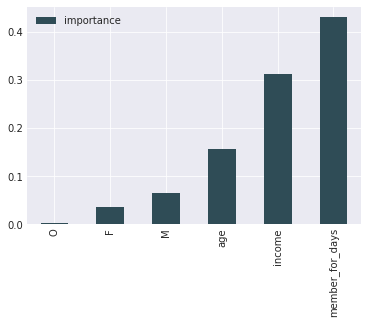

In [96]:
imps = models[0].best_estimator_.feature_importances_
labels = ['age','income','F','M','O', 'member_for_days']
xx = pd.DataFrame(imps, index= labels, columns= ['importance'])
xx.sort_values(by = 'importance').plot(kind = 'bar')
plt.show()

In [94]:
def regression_grid_search(prof_trans):
    
    '''Cross validation of the regression model to fit training data.
    INPUT:
        prof_trans (dataframe) : prof
    OUTPUT:
        gcv_rmodel (sklearn model instance) - trained  model
    '''
    
    data = prof_trans.loc[:,['age', 'income', 'F', 'M', 'O', 'member_for_days', 'avg_trans', 'trans_offer_ratio']]
    x = data.iloc[:,0:6]
    y = data.iloc[:,-2:]
    rmodel = RandomForestRegressor()
    
    param_grid = {'bootstrap': [True],
                  'max_depth': [80, 90, 100, 110],
                  'max_features': [2, 3],
                  'min_samples_leaf': [3, 4, 5],
                  'min_samples_split': [8, 10, 12],
                  'n_estimators': [100, 200, 300, 1000]}
    
    scoring = {'R2': 'r2', 'EV': 'explained_variance'}
    
    gcv_rmodel = GridSearchCV(rmodel, param_grid, scoring = scoring, refit = 'R2', cv=5, return_train_score=False)
    gcv_rmodel.fit(x, y)
    joblib.dump(gcv_rmodel, 'rmodel.model')
  
    return gcv_rmodel

In [ ]:
rmodel = regression_grid_search(prof_trans.dropna(subset=['avg_trans'], axis=0))

In [ ]:
imps = rmodel.best_estimator_.feature_importances_
labels = ['age','income','F','M','O', 'member_for_days']
x = pd.DataFrame(imps, index= labels, columns= ['importance'])
x.sort_values(by = 'importance').plot(kind = 'barh')
plt.show()

In [ ]:
def pred_trans_influence(age, income, gender, member_for_days, rmodel):
    
    '''Tries to predict the transactions by user and what part is influenced by the offer.
    
    INPUT:
        age (int): user's age
        income (float): user's income
        gender(str): F = Female , M = Male, O = Other or Undisclosed
        member_for_days (int) : Days a user has been a member
        rmodel (sklearn model instance) : regression model
    OUTPUT:
        preds (list) : List of Total Transactions with % of transaction influenced through offers
    '''
    user_data = prep_input(age, income, gender, member_for_days)
    preds = rmodel.predict(user_data)
    
    return preds.tolist()[0]

In [ ]:
def pred_offer_trans(age, income, gender, member_for_days, n, models, rmodel):
    
    '''Gives the best offers with the prediction of the user proportionate to transaction influenced by the offer
       
        INPUT:
            age (int): user's age
            income (float): user's income
            gender(str): F = Female , M = Male, O = Other or Undisclosed
            member_for_days (int) : Days a user has been a member
            n (int) : Best offers
            models (list) : List of models to calculate probability effectiveness
            rmodel (sklearn model instance) : regression model
        OUTPUT:
            n/a
           
    '''
    top_offers = predict_best_offers(age, income, gender, member_for_days, models, n)
    trans_infl = pred_trans_influence(age, income, gender, member_for_days, rmodel)
    print('The best offers for this user are:')
    for i in top_offers:
        print(i)
    print('\n')
    
    print('This user will have a transaction of ${} and {}% of it will be influenced by offer.'.format(round(trans_infl[0], 2), round(trans_infl[1]*100, 2)))

In [ ]:
pred_offer_trans(25, 65000, 'M', 19, 3, models, rmodel)

# Final Summary
### Performance of the Classification Models

The model with the highest fscore of 0.85 it discount_10_2_10. While the lowest score still met our evalutation criteria at 0.72 which is the bogo_10_10_7. The processing time for all of the models felt long (around 6 hours for my PC to run it all) but it could be nominal for larger companies like Starbucks who have much strong processing power than a single dual core laptop.

### Performance of the Regression Model

Overall it did not do well, with an low R2 it would not be a good model for predicting behavior for users. Part of the reason could be due to the complex nature of the data and large variation without enough detail. More features such as race/location/etc could provide a clearer picture on how to market to the users more efficently.

### Possible Improvements
More data can be collected, stronger processing power can be used, and a larger variety of offers could provide more insight into customer 
